<a href="https://colab.research.google.com/github/udaygupta8899/Micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
def f(x):
  return 3*x**2 -4*x +5

In [ ]:
ys=f(xs)

In [ ]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

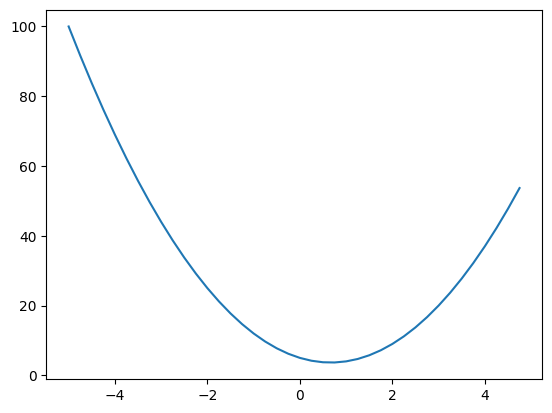

In [ ]:
plt.plot(xs,ys)

In [ ]:
class Value:
  def __init__(self,data, _children=(),_op="",label=''):
    self.data=data
    self.grad=0.0
    self._backward=lambda:None
    self._prev=set(_children)
    self._op=_op
    self.label=label
  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data + other.data,(self,other),'+')
    def _backward():
      self.grad+=1.0*out.grad
      other.grad+=1.0*out.grad
    out._backward=_backward
    return out
  def __neg__(self):
    return self*-1
  def __radd__(self,other):
    return self+other
  def __sub__(self,other):
    return self+(-other)
  def __rsub__(self,other):
    return other+(-self)
  def __pow__(self,other):
    assert isinstance(other,(int,float)),"only supporting int/float powers for now"
    out=Value(self.data**other,(self,),f'**{other}')
    def _backward():
      self.grad+=other*(self.data**(other-1))*out.grad
    out._backward=_backward
    return out
  def __mul__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    out=Value(self.data * other.data,(self,other),'*')
    def _backward():
      self.grad+=other.data*out.grad
      other.grad+=self.data*out.grad
    out._backward=_backward
    return out
  def __rmul__(self,other):
    return self*other
  def __truediv__(self,other):
    other=other if isinstance(other,Value) else Value(other)
    return self*other**-1
  def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t,(self,),'tanh')
    def _backward():
      self.grad+=(1-t**2)*out.grad
    out._backward=_backward
    return out
  def exp(self):
    x=self.data
    out=Value(math.exp(x),(self,),'exp')
    def _backward():
      self.grad+=out.data*out.grad
    out._backward=_backward
    return out
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(3,label='a')
b = Value(-2,label='b')
c=Value(10,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2,label='f')
L=d*f;L.label='L'
L

Value(data=-8)

In [ ]:
d._prev

{Value(data=-6), Value(data=10)}

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

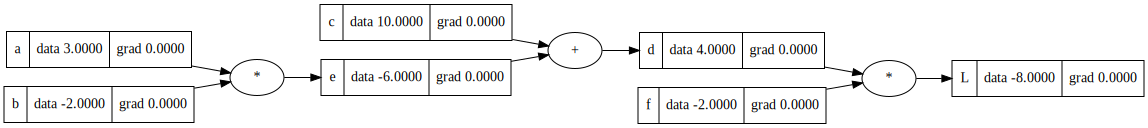

In [ ]:
draw_dot(L)

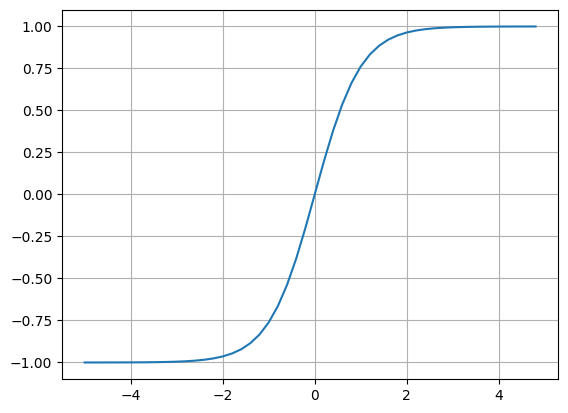

In [ ]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); plt.grid();     #Tanh function

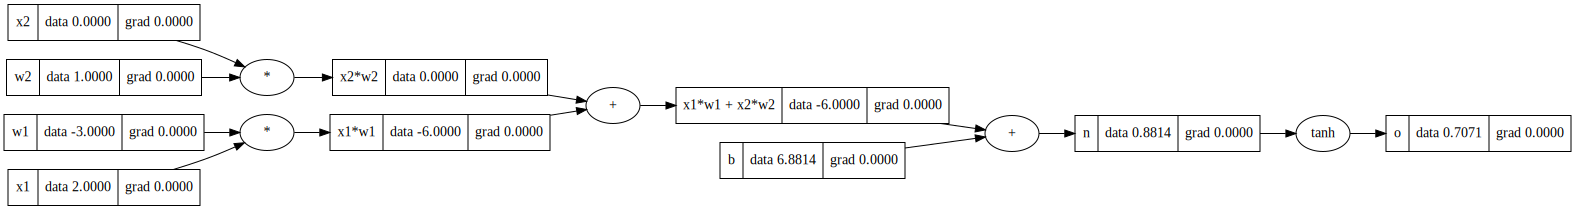

In [ ]:
#inputs x1,x2
x1,x2=Value(2.0,label='x1'),Value(0.0,label='x2')
#Weights w1,w2
w1,w2=Value(-3.0,label='w1'),Value(1.0,label='w2')
#Bias
b=Value(6.8813735870195432,label='b')
#x1*w1+x2*w2+b
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'
draw_dot(o)

In [ ]:
o.backward()

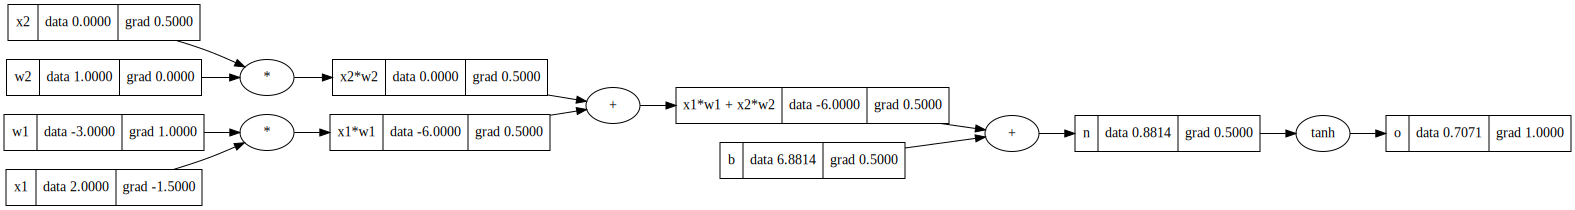

In [ ]:
draw_dot(o)

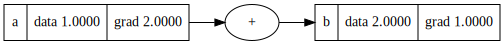

In [ ]:
a=Value(1,label='a')
b=a+a;b.label='b';
b.backward()
draw_dot(b)

In [ ]:
a + 1

Value(data=2)

In [ ]:
a * 2

Value(data=2)

In [ ]:
2 * a

Value(data=2)

In [ ]:
3 * a

Value(data=3)

In [ ]:
a**3

Value(data=1)

In [ ]:
a -1

Value(data=0)

In [ ]:
1 - a

Value(data=0)

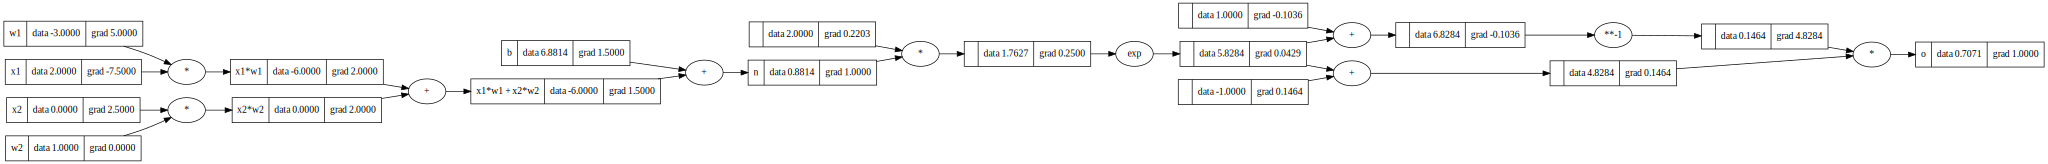

In [ ]:
e=(2*n).exp()
o = (e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
x1=torch.Tensor([2.0]).double();x1.requires_grad=True
x2=torch.Tensor([0.0]).double();x2.requires_grad=True
w1=torch.Tensor([-3.0]).double();w1.requires_grad=True
w2=torch.Tensor([1.0]).double();w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double();b.requires_grad=True
n=x1*w1+x2*w2+b
o=torch.tanh(n)

In [ ]:
print(o.data.item())

0.7071066904050358


In [ ]:
o.backward()

In [ ]:
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [ ]:
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]
class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.8367719609414266)

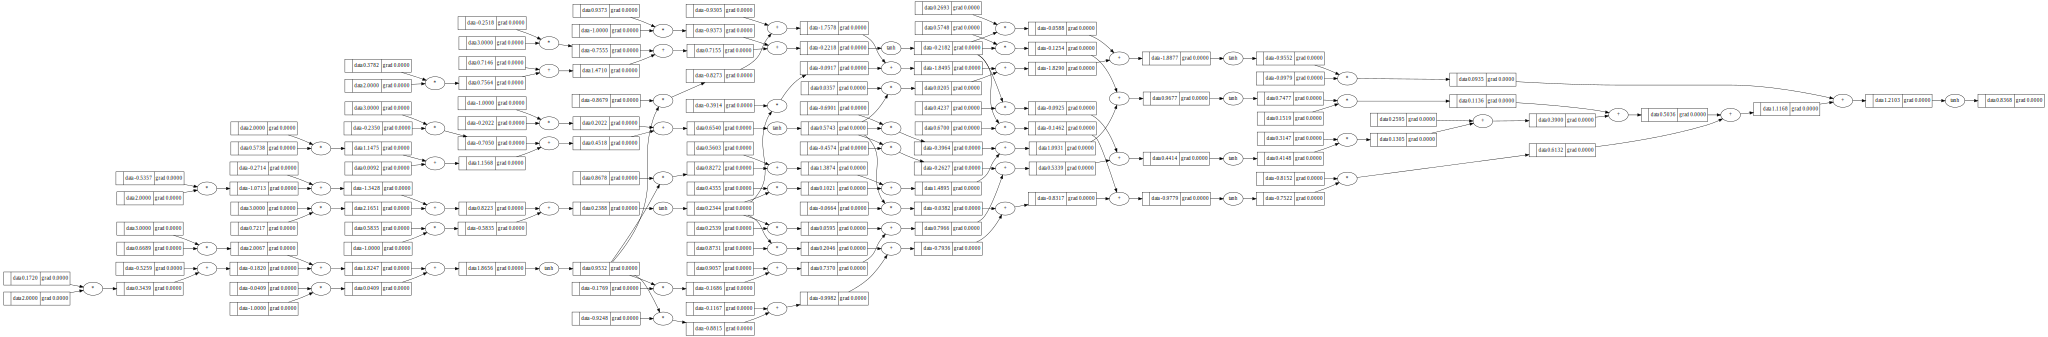

In [ ]:
draw_dot(n(x))

In [ ]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0] #Desired targets
ypred=[n(x) for x in xs]
ypred

[Value(data=0.8367719609414266),
 Value(data=0.21212976803395303),
 Value(data=0.17712681226091193),
 Value(data=0.8094852110552637)]

In [ ]:
loss=sum([(ygt-yout)**2 for ygt,yout in zip(ys,ypred)])
loss

Value(data=2.917825384239146)

In [ ]:
loss.backward()

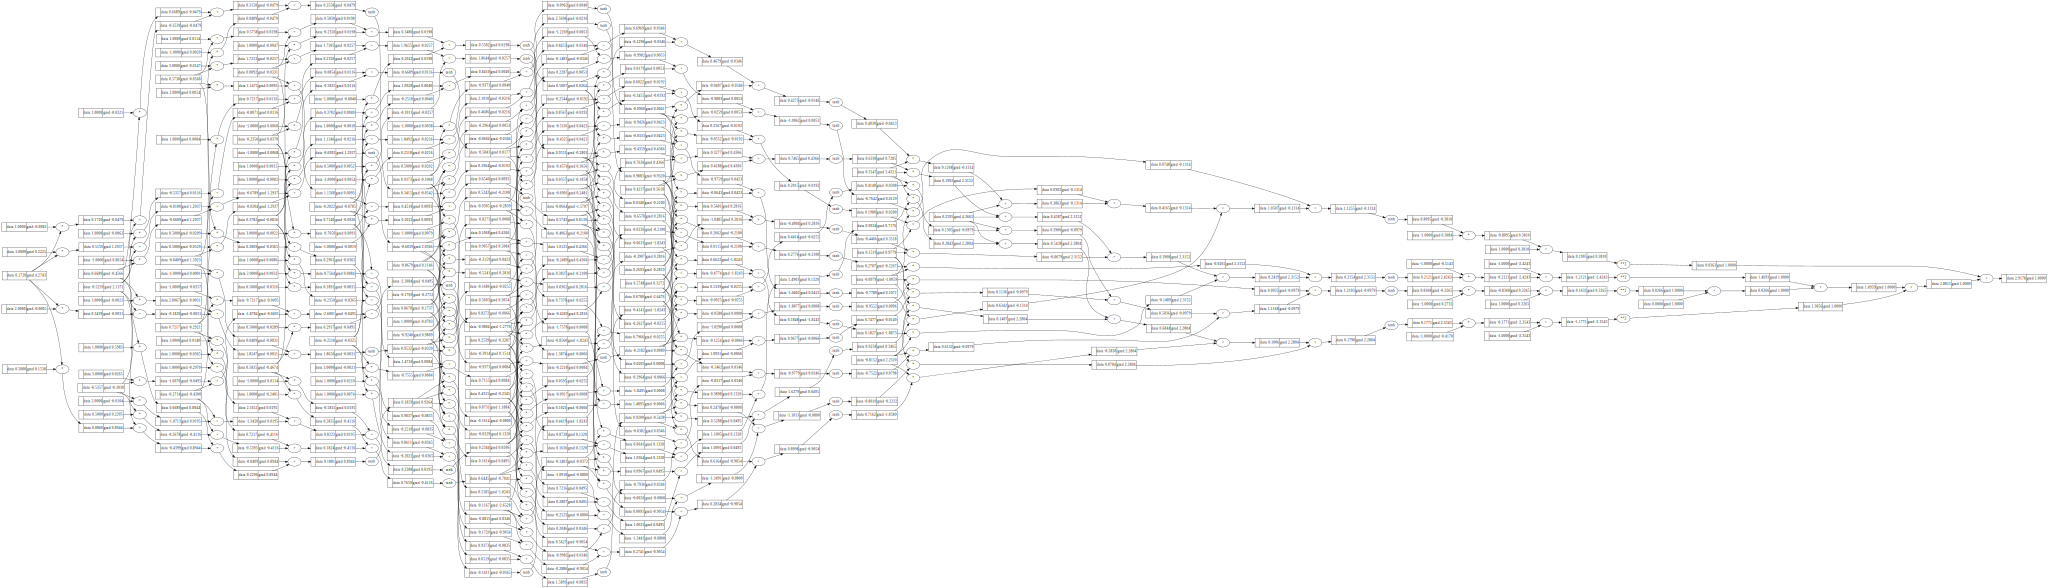

In [ ]:
draw_dot(loss)

In [ ]:
for k in range(200):
  #forward pass
  ypred=[n(x) for x in xs]
  loss=sum([(ygt-yout)**2 for ygt,yout in zip(ys,ypred)])

  #backward pass
  for p in n.parameters():
    p.grad=0.0
  loss.backward()
  #update
  for p in n.parameters():
    p.data+=-0.05*p.grad
  print(k,loss.data)

0 0.004511574200222532
1 0.004489122543116936
2 0.004466881243253569
3 0.004444847408746497
4 0.0044230182000537825
5 0.004401390828803732
6 0.004379962556652624
7 0.004358730694172872
8 0.004337692599770687
9 0.004316845678631986
10 0.004296187381696332
11 0.004275715204657355
12 0.004255426686989432
13 0.004235319410999491
14 0.004215391000903219
15 0.004195639121925044
16 0.00417606147942133
17 0.004156655818025472
18 0.004137419920815242
19 0.004118351608500659
20 0.004099448738632615
21 0.004080709204831205
22 0.004062130936033385
23 0.0040437118957592465
24 0.004025450081396461
25 0.004007343523502475
26 0.003989390285123686
27 0.003971588461131388
28 0.0039539361775738045
29 0.00393643159104394
30 0.003919072888062517
31 0.0039018582844760276
32 0.003884786024869081
33 0.0038678543819906253
34 0.0038510616561941518
35 0.0038344061748909032
36 0.0038178862920160753
37 0.0038015003875075636
38 0.0037852468667969137
39 0.003769124160312216
40 0.003753130722992336
41 0.0037372650338

In [ ]:
ypred

[Value(data=0.9805587417836896),
 Value(data=-0.9815986549695342),
 Value(data=-0.9720205149986928),
 Value(data=0.9733078342968002)]

In [ ]:
ys

[1.0, -1.0, -1.0, 1.0]